# Lab 1: Exploring NFL Play-By-Play Data

## Data Loading and Preprocessing

To begin, we load the data into a Pandas data frame from a csv file.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/data.csv') # read in the csv file

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's take a cursory glance at the data to see what we're working with.

In [ ]:
df.head()

There's a lot of data that we don't care about. For example, 'PassAttempt' is a binary attribute, but there's also an attribute called 'PlayType' which is set to 'Pass' for a passing play.

We define a list of the columns which we're not interested in, and then we delete them

In [3]:
columns_to_delete = ['Unnamed: 0', 'Date', 'time', 'TimeUnder', 
                     'PosTeamScore', 'PassAttempt', 'RushAttempt', 
                     'DefTeamScore', 'Season', 'PlayAttempted']

#Iterate through and delete the columns we don't want
for col in columns_to_delete:
    if col in df:
        del df[col]

We can then grab a list of the remaining column names

In [9]:
df.columns

Index(['GameID', 'Drive', 'qtr', 'down', 'TimeSecs', 'PlayTimeDiff',
       'SideofField', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo',
       'FirstDown', 'posteam', 'DefensiveTeam', 'desc', 'Yards.Gained', 'sp',
       'Touchdown', 'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'Safety',
       'PlayType', 'Passer', 'PassOutcome', 'PassLength', 'PassLocation',
       'InterceptionThrown', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap',
       'Receiver', 'Reception', 'ReturnResult', 'Returner', 'Tackler1',
       'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'Fumble',
       'RecFumbTeam', 'RecFumbPlayer', 'Sack', 'Challenge.Replay',
       'ChalReplayResult', 'Accepted.Penalty', 'PenalizedTeam', 'PenaltyType',
       'PenalizedPlayer', 'Penalty.Yards', 'ScoreDiff', 'AbsScoreDiff'],
      dtype='object')

Temporary simple data replacement so that we can cast to integers (instead of objects)

In [4]:
df = df.replace(to_replace=np.nan,value=-1)

At this point, lots of things are encoded as objects, or with excesively large data types

In [ ]:
df.info()

We define four lists based on the types of features we're using.
Binary features are separated from the other categorical features so that they can be stored in less space

In [5]:
continuous_features = ['TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100',
                       'ydstogo', 'ydsnet', 'Yards.Gained', 'Penalty.Yards',
                       'ScoreDiff', 'AbsScoreDiff']

ordinal_features = ['Drive', 'qtr', 'down']
binary_features = ['GoalToGo', 'FirstDown','sp', 'Touchdown', 'Safety', 'Fumble']
categorical_features = df.columns.difference(continuous_features).difference(ordinal_features)

We then cast all of the columns to the appropriate underlying data types

In [6]:
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[binary_features] = df[binary_features].astype(np.int8)

THIS IS SOME MORE REFORMATTING SHIT I'M DOING FOR NOW. PROLLY GONNA KEEP IT

In [21]:
df['PassOutcome'].replace(['Complete', 'Incomplete Pass'], [1, 0], inplace=True)

Now all of the objects are encoded the way we'd like them to be

In [ ]:
df.info()

Now we can start to take a look at what's in each of our columns

In [10]:
df.describe()

count     46129
unique       15
top        Pass
freq      18323
Name: PlayType, dtype: object

In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
#Embed figures in the Jupyter Notebook
%matplotlib inline

#Use GGPlot style for matplotlib
plt.style.use('ggplot')

In [22]:
pass_plays = df[df['PlayType'] == "Pass"]
pass_plays_grouped = pass_plays.groupby(by=['Passer'])

We can take a random sample of passers and show their completion rate:

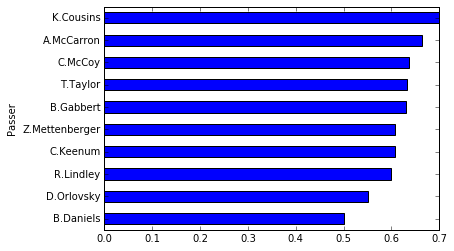

In [34]:
completion_rate = pass_plays_grouped.PassOutcome.sum() / pass_plays_grouped.PassOutcome.count()
completion_rate_sampled = completion_rate.sample(10)
completion_rate_sampled.sort_values(inplace=True)
completion_rate_sampled.plot(kind='barh')

We can also group by both passer and receiver, to check for highly effective QB-Receiver combos.

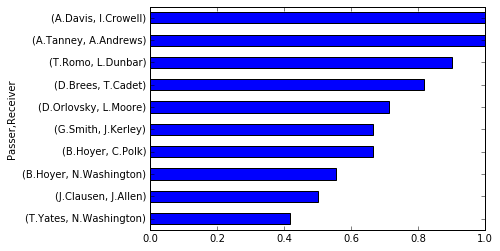

In [76]:
pass_plays_grouped = pass_plays.groupby(by=['Passer', 'Receiver'])
completion_rate = pass_plays_grouped.PassOutcome.sum() / pass_plays_grouped.PassOutcome.count()
completion_rate_sampled = completion_rate.sample(10)
completion_rate_sampled.sort_values(inplace=True)
completion_rate_sampled.plot(kind='barh')

We can eliminate combos who didn't have at least 10 receptions together, and then re-sample the data. This will remove noise from QB-receiver combos who have very high or low completion rates because they've played very little together.

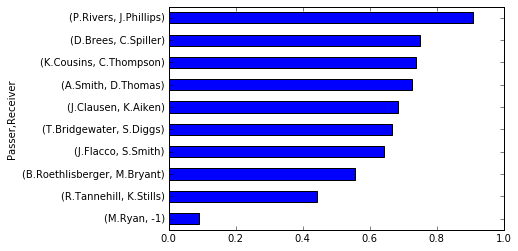

In [97]:
pass_plays_grouped_filtered = pass_plays_grouped.filter(lambda g: len(g)>10).groupby(by=['Passer', 'Receiver'])
completion_rate = pass_plays_grouped_filtered.PassOutcome.sum() / pass_plays_grouped_filtered.PassOutcome.count()
completion_rate_sampled = completion_rate.sample(10)
completion_rate_sampled.sort_values(inplace=True)
completion_rate_sampled.plot(kind='barh')

We can also extract the highest-completion percentage combos.
Here we take the top-10 most reliable QB-receiver pairs.

In [101]:
completion_rate.sort_values(inplace=True, ascending = False)
completion_rate = pd.Series(completion_rate)
completion_rate[1:10]

Passer            Receiver   
B.Roethlisberger  D.Williams     1.000000
M.Schaub          J.Allen        0.941176
M.Vick            L.Bell         0.933333
D.Carr            L.Smith        0.923077
D.Brees           T.Hightower    0.923077
P.Rivers          J.Phillips     0.909091
B.Hoyer           A.Blue         0.909091
T.Romo            J.Witten       0.894737
S.Bradford        B.Celek        0.894737
Name: PassOutcome, dtype: float64